# Tahu lah apa ini?

In [31]:
# from google.colab import drive
# drive.mount('/content/drive')
# Path to google drive folder
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002. Laporan-eksperimen
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002.Experiment_SWI_16052024/01.Dataset-Rofiqul/Ujicoba3-29052024

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBRegressor

from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from pyod.models.hbos import HBOS
from sklearn.cluster import DBSCAN, OPTICS
from scipy.spatial.distance import mahalanobis
from scipy.stats import zscore
from pyod.models.cblof import CBLOF
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import OneClassSVM

In [33]:
# Load the dataset
# file_path = '01.Dataset-Rofiqul/agriculture_dataset.csv'
# file_path = '01.Dataset-Rofiqul/Ujicoba3-29052024/agriculture_dataset.csv'
file_path = 'dataset/agriculture_dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset for review
# data.head(),data.info(),data.describe()

## Detect Nilai NaN

In [34]:

missing_values_count = data.isna().sum()
missing_values_count

Date            0
Year            0
Experiment      0
DataUse         0
Replication     0
Month           0
Vegetation      0
VegType         0
N2O             0
N_rate          0
PP2             0
PP7             0
AirT            0
DAF_TD          0
DAF_SD          0
WFPS25cm       52
NH4            76
NO3            30
Clay            0
Sand            0
SOM             0
dtype: int64

## Impute Missing Value with Mean

In [35]:
# Impute missing values with the mean of the respective columns
data['WFPS25cm'].fillna(data['WFPS25cm'].mean(), inplace=True)
data['NH4'].fillna(data['NH4'].mean(), inplace=True)
data['NO3'].fillna(data['NO3'].mean(), inplace=True)

# Verify that there are no missing values left
missing_values_after_imputation = data.isna().sum()
missing_values_after_imputation

/tmp/ipykernel_2552/190507584.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['WFPS25cm'].fillna(data['WFPS25cm'].mean(), inplace=True)
/tmp/ipykernel_2552/190507584.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

Date           0
Year           0
Experiment     0
DataUse        0
Replication    0
Month          0
Vegetation     0
VegType        0
N2O            0
N_rate         0
PP2            0
PP7            0
AirT           0
DAF_TD         0
DAF_SD         0
WFPS25cm       0
NH4            0
NO3            0
Clay           0
Sand           0
SOM            0
dtype: int64

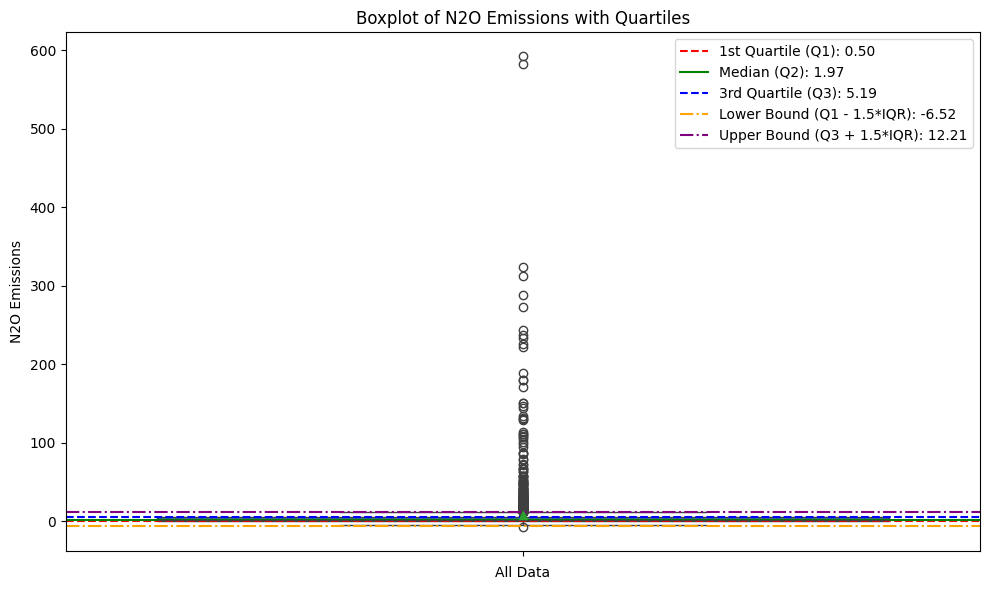

In [36]:


# Assuming your data is already loaded into a DataFrame called 'data'

# Generate a box plot for N2O with quartile divisions
plt.figure(figsize=(10, 6))

# Boxplot for N2O with quartiles
sns.boxplot(y='N2O', data=data, showmeans=True)
plt.title('Boxplot of N2O Emissions with Quartiles')
plt.ylabel('N2O Emissions')
plt.xlabel('All Data')

# Calculate quartiles and IQR
q1 = data['N2O'].quantile(0.25)
q2 = data['N2O'].median()
q3 = data['N2O'].quantile(0.75)
iqr = q3 - q1

# Adding horizontal lines for quartiles and IQR
plt.axhline(q1, color='r', linestyle='--', label=f'1st Quartile (Q1): {q1:.2f}')
plt.axhline(q2, color='g', linestyle='-', label=f'Median (Q2): {q2:.2f}')
plt.axhline(q3, color='b', linestyle='--', label=f'3rd Quartile (Q3): {q3:.2f}')
plt.axhline(q1 - 1.5 * iqr, color='orange', linestyle='-.', label=f'Lower Bound (Q1 - 1.5*IQR): {q1 - 1.5 * iqr:.2f}')
plt.axhline(q3 + 1.5 * iqr, color='purple', linestyle='-.', label=f'Upper Bound (Q3 + 1.5*IQR): {q3 + 1.5 * iqr:.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('visual/0905_01_BoxplotofN2OEmissionswithQuartiles.png', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
# Custom wrapper for DBSCAN to use in VotingClassifier
class DBSCANWrapper:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples)

    def fit(self, X, y=None):
        self.dbscan.fit(X)
        return self

    def predict(self, X):
        labels = self.dbscan.fit_predict(X)
        return np.where(labels == -1, -1, 1)

# Custom wrapper for Mahalanobis Distance to use in VotingClassifier
class MahalanobisWrapper:
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X, y=None):
        self.mean = np.mean(X, axis=0)
        self.cov_matrix = np.cov(X, rowvar=False) if X.shape[1] > 1 else np.array([[np.var(X, ddof=1)]])
        self.inv_cov_matrix = np.linalg.inv(self.cov_matrix)
        return self
    def predict(self, X):
        m_dist = np.array([mahalanobis(x, self.mean, self.inv_cov_matrix) for x in X])
        threshold = np.percentile(m_dist, 100 * (1 - self.contamination))
        return np.where(m_dist > threshold, -1, 1)
    # def predict(self, X):
    #     m_dist = np.array([mahalanobis(x.reshape(1, -1), self.mean, self.inv_cov_matrix) for x in X])
    #     threshold = np.percentile(m_dist, 100 * (1 - self.contamination))
    #     return np.where(m_dist > threshold, -1, 1)

# Function to detect outliers using IQR
def iqr_outliers(X):
    Q1 = np.percentile(X, 25, axis=0)
    Q3 = np.percentile(X, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.where((X < lower_bound) | (X > upper_bound), -1, 1)

# Function to detect outliers using Z-score
def zscore_outliers(X, threshold=3):
    z_scores = zscore(X)
    return np.where(np.abs(z_scores) > threshold, -1, 1)

# Function to detect outliers using Tukey Fences
def tukey_fences_outliers(X):
    Q1 = np.percentile(X, 25, axis=0)
    Q3 = np.percentile(X, 75, axis=0)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    return np.where((X < lower_fence) | (X > upper_fence), -1, 1)

In [38]:
df=data
df.info()
missing_values_count = data.isna().sum()
missing_values_count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246 entries, 0 to 2245
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         2246 non-null   object 
 1   Year         2246 non-null   int64  
 2   Experiment   2246 non-null   object 
 3   DataUse      2246 non-null   object 
 4   Replication  2246 non-null   object 
 5   Month        2246 non-null   object 
 6   Vegetation   2246 non-null   object 
 7   VegType      2246 non-null   object 
 8   N2O          2246 non-null   float64
 9   N_rate       2246 non-null   int64  
 10  PP2          2246 non-null   float64
 11  PP7          2246 non-null   float64
 12  AirT         2246 non-null   float64
 13  DAF_TD       2246 non-null   int64  
 14  DAF_SD       2246 non-null   int64  
 15  WFPS25cm     2246 non-null   float64
 16  NH4          2246 non-null   float64
 17  NO3          2246 non-null   float64
 18  Clay         2246 non-null   float64
 19  Sand  

Date           0
Year           0
Experiment     0
DataUse        0
Replication    0
Month          0
Vegetation     0
VegType        0
N2O            0
N_rate         0
PP2            0
PP7            0
AirT           0
DAF_TD         0
DAF_SD         0
WFPS25cm       0
NH4            0
NO3            0
Clay           0
Sand           0
SOM            0
dtype: int64

In [39]:
X = data[['N2O']].values
X.ndim

2

In [40]:
X

array([[ 3.89674168],
       [ 2.19021768],
       [ 3.54259441],
       ...,
       [-0.2       ],
       [ 0.3       ],
       [ 0.4       ]])

In [41]:

# Initialize the outlier detection models
models = [
    ('if', IsolationForest(contamination=0.1, random_state=42)),
    ('lof', LocalOutlierFactor(novelty=True, contamination=0.1)),
    ('ocsvm', OneClassSVM(nu=0.1)),
    ('elliptic', EllipticEnvelope(contamination=0.1)),
    ('hbos', HBOS()),
    ('dbscan', DBSCANWrapper(eps=0.5, min_samples=5)),
    ('mahalanobis', MahalanobisWrapper(contamination=0.1)),
    ('iqr', iqr_outliers),
    ('zscore', zscore_outliers),
    ('tukey', tukey_fences_outliers),
    ('optics', OPTICS(min_samples=5, cluster_method='xi')),
    ('cblof', CBLOF(contamination=0.1, check_estimator=False, random_state=42))
]


# Fit the models and predict outliers
# for name, model in models:
#     if name in ['iqr', 'zscore', 'tukey']:
#         data[f'{name}_outlier'] = model(X)
#     elif name == 'optics':
#         model.fit(X)
#         labels = model.labels_
#         data[f'{name}_outlier'] = np.where(labels == -1, -1, 1)
#     else:
#         model.fit(X)
#         data[f'{name}_outlier'] = model.predict(X)
# Fit the models and predict outliers
for name, model in models:
    if name in ['iqr', 'zscore', 'tukey']:
        data[f'{name}_outlier'] = model(X)
    elif name == 'optics':
        model.fit(X)
        labels = model.labels_
        data[f'{name}_outlier'] = np.where(labels == -1, -1, 1)
    elif name == 'cblof':
        model.fit(X)
        labels = model.labels_
        # data[f'{name}_outlier'] = np.where(labels == 1, 1, np.where(labels == -1, -1, 0))
        data[f'{name}_outlier'] = np.where(labels == 0, 1, -1)

    elif name == 'hbos':
        model.fit(X)
        labels = model.labels_
        data[f'{name}_outlier'] = np.where(labels == 0, 1, -1)
        # data[f'{name}_outlier'] = np.where(labels == 1, 1, np.where(labels == -1, -1, 0))
    else:
        model.fit(X)
        data[f'{name}_outlier'] = model.predict(X)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [42]:
# Count the number of zeros in HBOS and CBLOF results
hbos_zeros = (data['hbos_outlier'] == 0).sum()
cblof_zeros = (data['cblof_outlier'] == 0).sum()

# Print the counts of zeros
print("Number of zeros in HBOS results:", hbos_zeros)
print("Number of zeros in CBLOF results:", cblof_zeros)

# Verify the results
print("HBOS Outliers:\n", data['hbos_outlier'].value_counts())
print("CBLOF Outliers:\n", data['cblof_outlier'].value_counts())


Number of zeros in HBOS results: 0
Number of zeros in CBLOF results: 0
HBOS Outliers:
 hbos_outlier
 1    2197
-1      49
Name: count, dtype: int64
CBLOF Outliers:
 cblof_outlier
 1    2021
-1     225
Name: count, dtype: int64


In [43]:
data


,Date,Year,Experiment,DataUse,Replication,Month,Vegetation,VegType,N2O,N_rate,...,ocsvm_outlier,elliptic_outlier,hbos_outlier,dbscan_outlier,mahalanobis_outlier,iqr_outlier,zscore_outlier,tukey_outlier,optics_outlier,cblof_outlier
0,2/9/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.896742,170,...,1,1,1,1,1,1,1,1,1,1
1,2/10/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,2.190218,170,...,1,1,1,1,1,1,1,1,1,1
2,2/18/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.542594,170,...,1,1,1,1,1,1,1,1,-1,1
3,2/19/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.342870,170,...,1,1,1,1,1,1,1,1,1,1
4,3/16/12,2012,BCSE_KBS,Building,R1,March,Corn,Annual,2.947778,170,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,10/16/2013,2013,MCSE-T2,Testing,R4,October,TRIAE,Annual,1.640000,91,...,1,1,1,1,1,1,1,1,1,1
2242,11/15/2013,2013,MCSE-T2,Testing,R1,November,TRIAE,Annual,0.990000,91,...,1,1,1,1,1,1,1,1,-1,1
2243,11/15/2013,2013,MCSE-T2,Testing,R2,November,TRIAE,Annual,-0.200000,91,...,1,1,1,1,1,1,1,1,1,1
2244,11/15/2013,2013,MCSE-T2,Testing,R3,November,TRIAE,Annual,0.300000,91,...,1,1,1,1,1,1,1,1,1,1


In [44]:

# Save the results to a CSV file
output_file_path = 'dataset/09_05_3_0_AgricultureOutliersDetectionResults.csv'
data.to_csv(output_file_path, index=False)

In [45]:
# Initialize an empty DataFrame for storing the statistics
# statistics = pd.DataFrame(columns=['Method', 'Count Inliers', 'Count Outliers'])
# statistics=[]
statistics = pd.DataFrame(columns=['Method', 'Count Inliers', 'Count Outliers', 'Count Unidentified', 'Total Number'])
# Iterate over each outlier detection method
for name in data.columns:
    if name.endswith('_outlier'):
        method = name[:-8]  # Remove '_outlier' from the column name
        count_inliers = len(data[data[name] == 1])
        count_outliers = len(data[data[name] == -1])
        # statistics = statistics.append({'Method': method, 'Count Inliers': count_inliers, 'Count Outliers': count_outliers}, ignore_index=True)
        # statistics.loc[len(statistics)] = [method, count_inliers, count_outliers]
        count_unidentified = len(data[data[name] == 0])
        total_number = len(data)
        statistics.loc[len(statistics)] = [method, count_inliers, count_outliers, count_unidentified, total_number]# Display the statistics
print("Comparison Statistics: Outlier Detection Methods")
# print(statistics)
statistics


Comparison Statistics: Outlier Detection Methods


,Method,Count Inliers,Count Outliers,Count Unidentified,Total Number
0,if,2021,225,0,2246
1,lof,2072,174,0,2246
2,ocsvm,2022,224,0,2246
3,elliptic,2021,225,0,2246
4,hbos,2197,49,0,2246
5,dbscan,2157,89,0,2246
6,mahalanobis,2021,225,0,2246
7,iqr,1995,251,0,2246
8,zscore,2214,32,0,2246
9,tukey,1995,251,0,2246


In [46]:
# Save the results to a CSV file
output_file_path = 'dataset/09_05_3_1_AgricultureOutliersDetectionResultsSummary.csv'
statistics.to_csv(output_file_path, index=False)

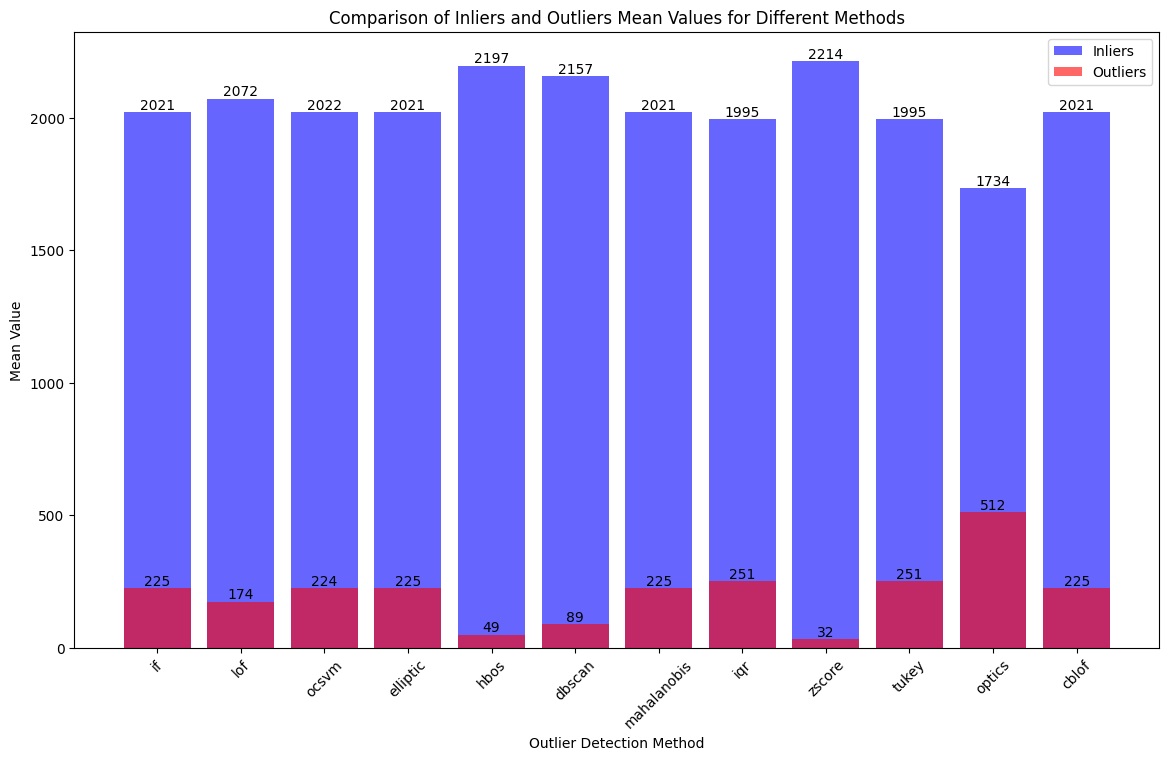

In [59]:
# Plotting
plt.figure(figsize=(14, 8))

# Bar plot for Outliers Mean
# bars3 = plt.bar(statistics['Method'], statistics['Total Number'], color='gray', alpha=0.6, label='Total')

# Bar plot for Inliers Mean
bars1 = plt.bar(statistics['Method'], statistics['Count Inliers'], color='blue', alpha=0.6, label='Inliers')

# Bar plot for Outliers Mean
bars2 = plt.bar(statistics['Method'], statistics['Count Outliers'], color='red', alpha=0.6, label='Outliers')

# # Add labels on top of each bar for Outliers Mean
# for bar in bars3:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')


# Add labels on top of each bar for Inliers Mean
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Add labels on top of each bar for Outliers Mean
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')
    

# Set the x-axis label
plt.xlabel('Outlier Detection Method')

# Set the y-axis label
plt.ylabel('Mean Value')

# Set the title
plt.title('Comparison of Inliers and Outliers Mean Values for Different Methods')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Save the plot as a PNG file
plt.savefig('visual/0905_11_ColumnComparisonOutliersInliers.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

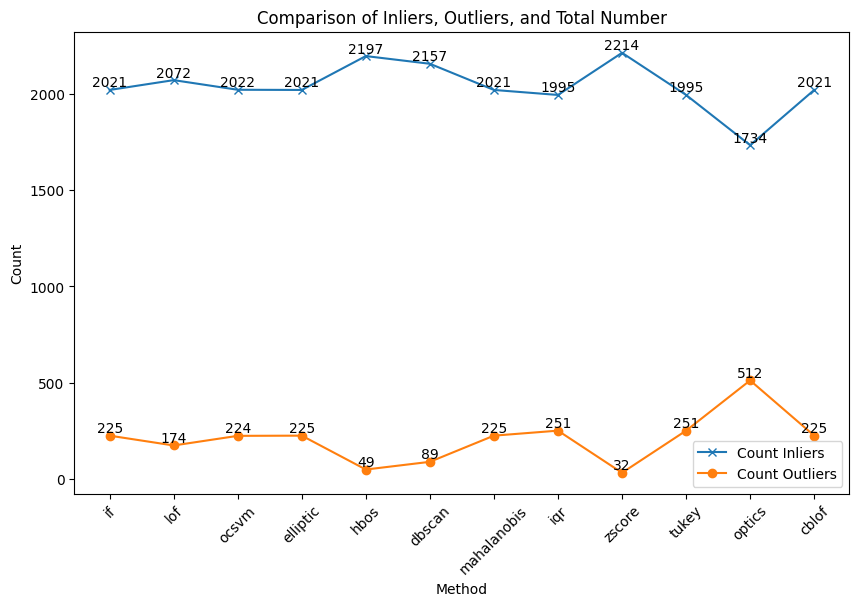

In [18]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the line for Count Inliers
plt.plot(statistics['Method'], statistics['Count Inliers'], marker='x', label='Count Inliers')

# Plot the line for Count Outliers
plt.plot(statistics['Method'], statistics['Count Outliers'], marker='o', label='Count Outliers')

# Plot the line for Total Number
# plt.plot(statistics['Method'], statistics['Total Number'], marker='o', label='Total Number')

# Set the x-axis label
plt.xlabel('Method')

# Set the y-axis label
plt.ylabel('Count')

# Set the title
plt.title('Comparison of Inliers, Outliers, and Total Number')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Add labels above each tick point for inliers
for i in range(len(statistics['Method'])):
    plt.text(i, statistics['Count Inliers'][i], f"{statistics['Count Inliers'][i]}", ha='center', va='bottom')

# Add labels above each tick point for outliers
for i in range(len(statistics['Method'])):
    plt.text(i, statistics['Count Outliers'][i], f"{statistics['Count Outliers'][i]}", ha='center', va='bottom')
# Add a legend
plt.legend()
plt.savefig('visual/0905_09_ComparisonOutliersInliers.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

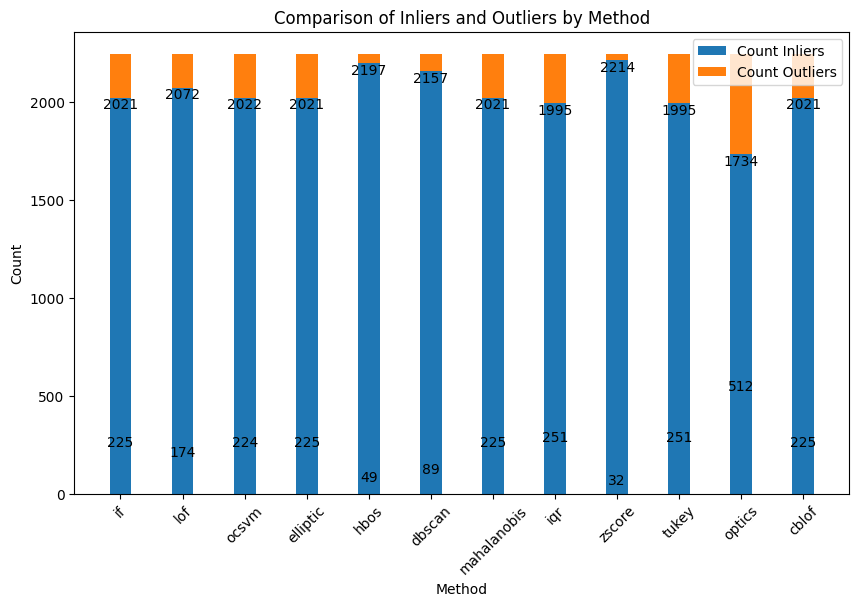

In [28]:

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the width of the bars
bar_width = 0.35

# Get the indexes for the x-axis
index = range(len(statistics))

# Plot the bars for Count Inliers
plt.bar(index, statistics['Count Inliers'], width=bar_width, label='Count Inliers')

# Plot the bars for Count Outliers
plt.bar(index, statistics['Count Outliers'], width=bar_width, label='Count Outliers', bottom=statistics['Count Inliers'])

# Set the x-axis label
plt.xlabel('Method')

# Set the y-axis label
plt.ylabel('Count')

# Set the title
plt.title('Comparison of Inliers and Outliers by Method')

# Set the x-axis ticks and labels
plt.xticks(index, statistics['Method'], rotation=45)
# Add labels above each tick point for inliers
for i in range(len(statistics['Method'])):
    plt.text(i, statistics['Count Inliers'][i], f"{statistics['Count Inliers'][i]}", ha='center', va='top')
# Add labels above each tick point for outliers
for i in range(len(statistics['Method'])):
    plt.text(i, statistics['Count Outliers'][i], f"{statistics['Count Outliers'][i]}", ha='center', va='bottom')
# Add a legend
plt.legend()
plt.savefig('visual/0905_10_BarplotComparisonInlierOutlier.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [21]:
data

,Date,Year,Experiment,DataUse,Replication,Month,Vegetation,VegType,N2O,N_rate,...,ocsvm_outlier,elliptic_outlier,hbos_outlier,dbscan_outlier,mahalanobis_outlier,iqr_outlier,zscore_outlier,tukey_outlier,optics_outlier,cblof_outlier
0,2/9/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.896742,170,...,1,1,1,1,1,1,1,1,1,1
1,2/10/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,2.190218,170,...,1,1,1,1,1,1,1,1,1,1
2,2/18/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.542594,170,...,1,1,1,1,1,1,1,1,-1,1
3,2/19/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.342870,170,...,1,1,1,1,1,1,1,1,1,1
4,3/16/12,2012,BCSE_KBS,Building,R1,March,Corn,Annual,2.947778,170,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,10/16/2013,2013,MCSE-T2,Testing,R4,October,TRIAE,Annual,1.640000,91,...,1,1,1,1,1,1,1,1,1,1
2242,11/15/2013,2013,MCSE-T2,Testing,R1,November,TRIAE,Annual,0.990000,91,...,1,1,1,1,1,1,1,1,-1,1
2243,11/15/2013,2013,MCSE-T2,Testing,R2,November,TRIAE,Annual,-0.200000,91,...,1,1,1,1,1,1,1,1,1,1
2244,11/15/2013,2013,MCSE-T2,Testing,R3,November,TRIAE,Annual,0.300000,91,...,1,1,1,1,1,1,1,1,1,1


In [20]:
# Select the feature and class columns
feature_column = 'N2O'
class_column = 'majority_voting'

# Create a box plot
plt.figure(figsize=(8, 6))
plt.boxplot(data[feature_column].groupby(data[class_column]).apply(list))
plt.xlabel(class_column)
plt.ylabel(feature_column)
plt.title(f"Box Plot of {feature_column} by {class_column}")
plt.show()

KeyError: 'majority_voting'

<Figure size 800x600 with 0 Axes>

KeyError: 'Inliers Median'

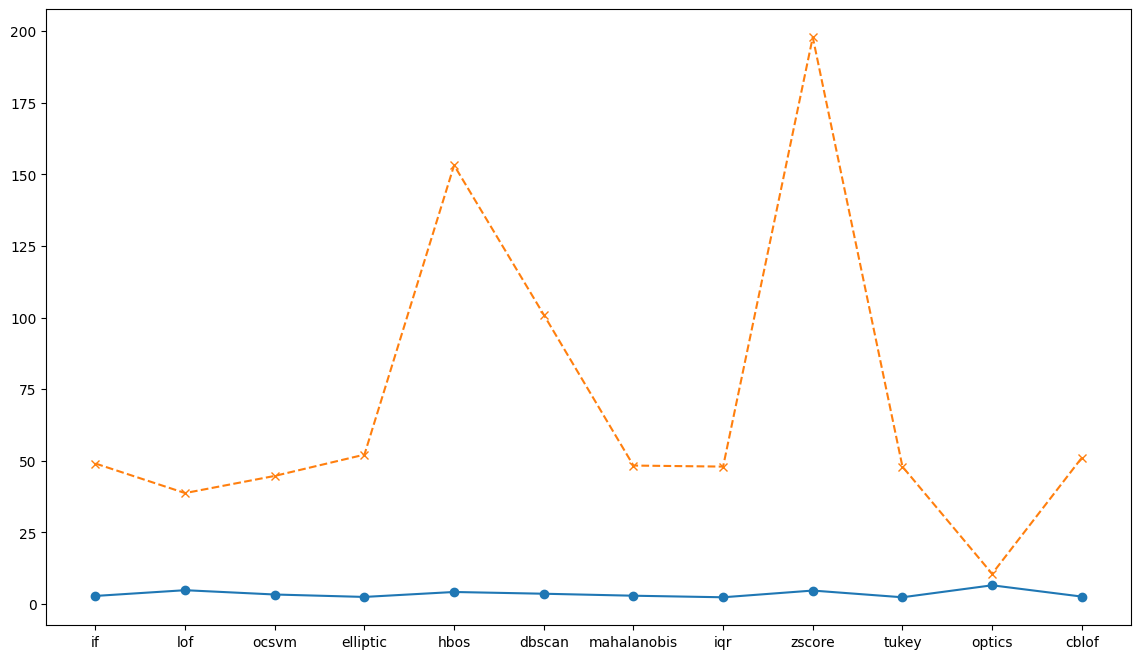

In [29]:
# Create summary statistics
summary_stats = []
for name, _ in models:
    inliers = data.loc[data[f'{name}_outlier'] == 1, 'N2O']
    outliers = data.loc[data[f'{name}_outlier'] == -1, 'N2O']
    
    summary_stats.append({
        'Method': name,
        'Inliers Mean': inliers.mean(),
        # 'Inliers Median': inliers.median(),
        # 'Inliers Std': inliers.std(),
        'Outliers Mean': outliers.mean(),
        # 'Outliers Median': outliers.median(),
        # 'Outliers Std': outliers.std()
    })

summary_df = pd.DataFrame(summary_stats)

# Plotting
plt.figure(figsize=(14, 8))
for stat in ['Mean', 'Median', 'Std']:
    plt.plot(summary_df['Method'], summary_df[f'Inliers {stat}'], marker='o', label=f'Inliers {stat}')
    plt.plot(summary_df['Method'], summary_df[f'Outliers {stat}'], marker='x', linestyle='--', label=f'Outliers {stat}')

plt.xlabel('Outlier Detection Method')
plt.ylabel('Summary Statistics')
plt.title('Comparison of Outlier vs Inlier Summary Statistics for Different Methods')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

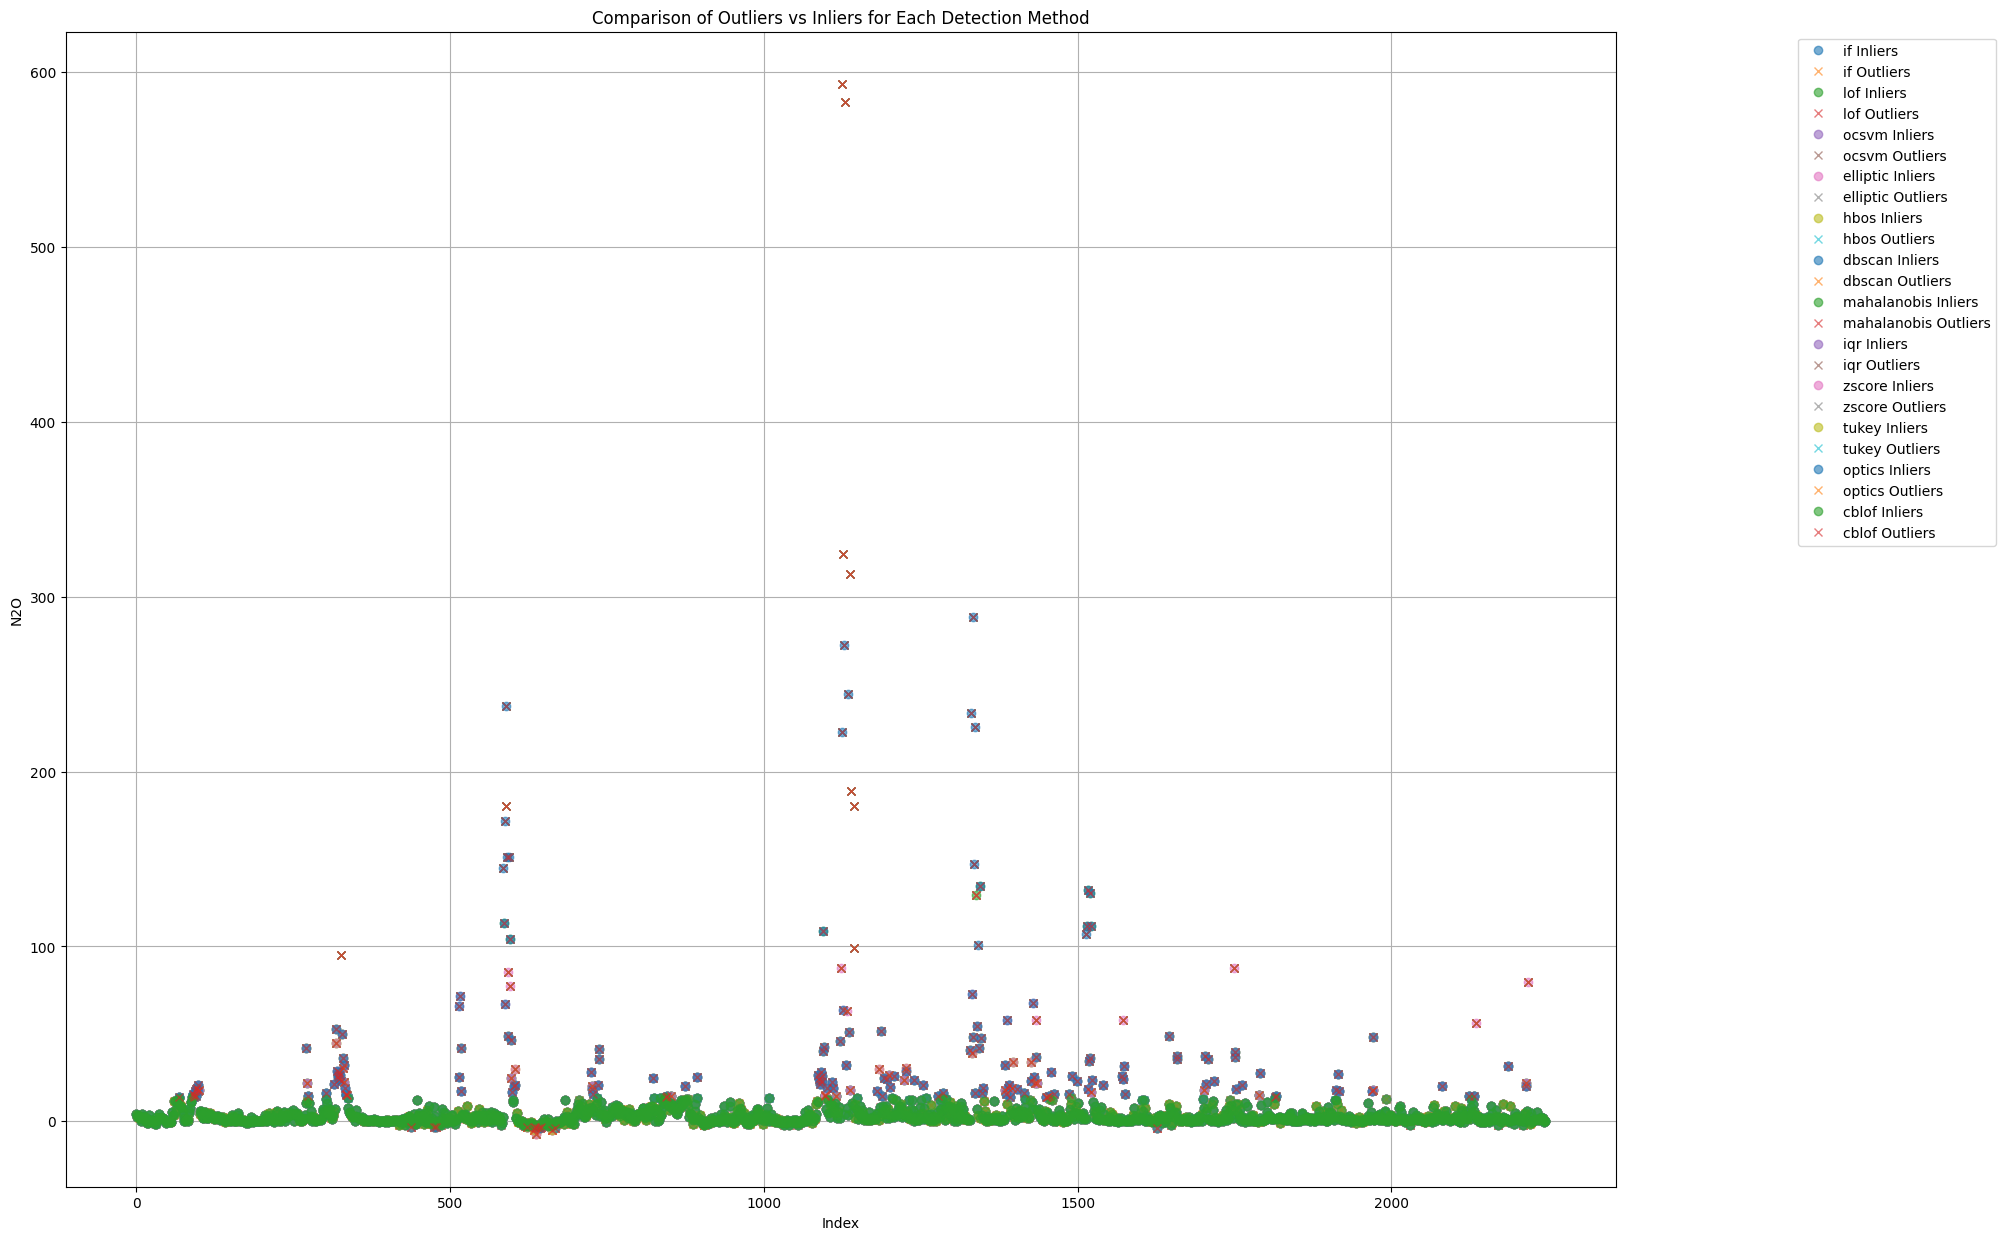

In [67]:
# Plotting the comparison of outliers vs inliers for each method
plt.figure(figsize=(20, 15))

for name, model in models:
    outlier_col = f'{name}_outlier'
    inlier_indices = data.index[data[outlier_col] == 1]
    outlier_indices = data.index[data[outlier_col] == -1]
    plt.plot(inlier_indices, data.loc[inlier_indices, 'N2O'], 'o', label=f'{name} Inliers', alpha=0.6)
    plt.plot(outlier_indices, data.loc[outlier_indices, 'N2O'], 'x', label=f'{name} Outliers', alpha=0.6)

plt.xlabel('Index')
plt.ylabel('N2O')
plt.title('Comparison of Outliers vs Inliers for Each Detection Method')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid(True)
plt.show()

## Evaluation Matrix

In [66]:

# Generate synthetic ground truth labels for evaluation purposes
# Here, we'll assume that '1' indicates inliers and '-1' indicates outliers in the original data
# This is just for the sake of comparison; in a real scenario, ground truth labels would be known
# Creating a synthetic ground truth based on majority voting of outliers
# data['majority_voting'] = data.apply(lambda row: 1 if row[['IF_Outlier', 'LOF_Outlier', 'OCSVM_Outlier', 'Elliptic_Outlier', 'HBOS_Outlier', 'DBSCAN_Outlier', 'Mahalanobis_Outlier']].mode()[0] == 1 else -1, axis=1)

# Calculate precision, recall, and F1-score for each method
evaluation_metrics = {}

# methods = ['IF_Outlier', 'LOF_Outlier', 'OCSVM_Outlier', 'Elliptic_Outlier', 'HBOS_Outlier', 'DBSCAN_Outlier', 'Mahalanobis_Outlier']
methods = ['if_outlier', 'lof_outlier', 'ocsvm_outlier', 'elliptic_outlier', 'hbos_outlier', 'dbscan_outlier', 'mahalanobis_outlier']

for method in methods:
    precision = precision_score(data['majority_voting'], data[method], pos_label=-1, average='macro')
    recall = recall_score(data['majority_voting'], data[method], pos_label=-1, average='macro')
    f1 = f1_score(data['majority_voting'], data[method], pos_label=-1, average='macro')
    evaluation_metrics[method] = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}


# Convert the evaluation metrics to a DataFrame for better visualization
evaluation_df = pd.DataFrame(evaluation_metrics).T

# Save the evaluation results to a CSV file
evaluation_df.to_csv('dataset/09_05_2_n2o_outlier_detection_evaluation.csv', index=True)

# Display the evaluation results
evaluation_df

NameError: name 'precision_score' is not defined

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score

# Generate synthetic ground truth labels for evaluation purposes
# data['Majority_Voting'] = data.apply(lambda row: 1 if row[['IF_Outlier', 'LOF_Outlier', 'OCSVM_Outlier', 'Elliptic_Outlier', 'HBOS_Outlier', 'DBSCAN_Outlier', 'Mahalanobis_Outlier']].mode()[0] == 1 else -1, axis=1)
data['majority_voting'] = data.apply(lambda row: 1 if row[['if_outlier', 'lof_outlier', 'ocsvm_outlier', 'elliptic_outlier', 'hbos_outlier', 'dbscan_outlier', 'mahalanobis_outlier']].mode()[0] == 1 else -1, axis=1)

# Convert outlier labels to binary (1 for outliers, 0 for inliers) for evaluation metrics
y_true = (data['majority_voting'] == -1).astype(int)

# Calculate evaluation metrics for each method
evaluation_metrics = {}

# methods = ['IF_Outlier', 'LOF_Outlier', 'OCSVM_Outlier', 'Elliptic_Outlier', 'HBOS_Outlier', 'DBSCAN_Outlier', 'Mahalanobis_Outlier']
method=['if_outlier', 'lof_outlier', 'ocsvm_outlier', 'elliptic_outlier', 'hbos_outlier', 'dbscan_outlier', 'mahalanobis_outlier']

for method in methods:
    y_pred = (data[method] == -1).astype(int)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    ade = np.mean(np.abs(y_true - y_pred))

    evaluation_metrics[method] = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Average Precision': ap,
        'AUC-ROC': auc_roc,
        'ADE': ade
    }

# Convert the evaluation metrics to a DataFrame for better visualization
evaluation_df = pd.DataFrame(evaluation_metrics).T

# Save the evaluation results to a CSV file
evaluation_df.to_csv('dataset/09_05_3_AgricultureOutliersEvaluationMatrix_30052024.csv', index=True)

# Save the updated data with outlier detection results
data.to_csv('dataset/09_05_3_AgricultureOutliersResultMatrix_30052024.csv', index=False)

# Display the evaluation results
# print(evaluation_df)
evaluation_df

# Display the updated dataframe with outlier detection results
# print(data.head())

                     Precision    Recall  F1-Score  Average Precision  \
if_outlier            0.933333  0.523691  0.670927           0.573818   
lof_outlier           1.000000  0.433915  0.605217           0.534984   
ocsvm_outlier         1.000000  0.558603  0.716800           0.637410   
elliptic_outlier      0.933333  0.523691  0.670927           0.573818   
hbos_outlier          0.000000  0.000000  0.000000           0.178540   
dbscan_outlier        1.000000  0.221945  0.363265           0.360859   
mahalanobis_outlier   0.000000  0.000000  0.000000           0.178540   

                      AUC-ROC       ADE  
if_outlier           0.757780  0.091719  
lof_outlier          0.716958  0.101069  
ocsvm_outlier        0.779302  0.078807  
elliptic_outlier     0.757780  0.091719  
hbos_outlier         0.500000  0.178540  
dbscan_outlier       0.610973  0.138914  
mahalanobis_outlier  0.500000  0.178540  
      Date  Year Experiment   DataUse Replication     Month Vegetation  \
0   2

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


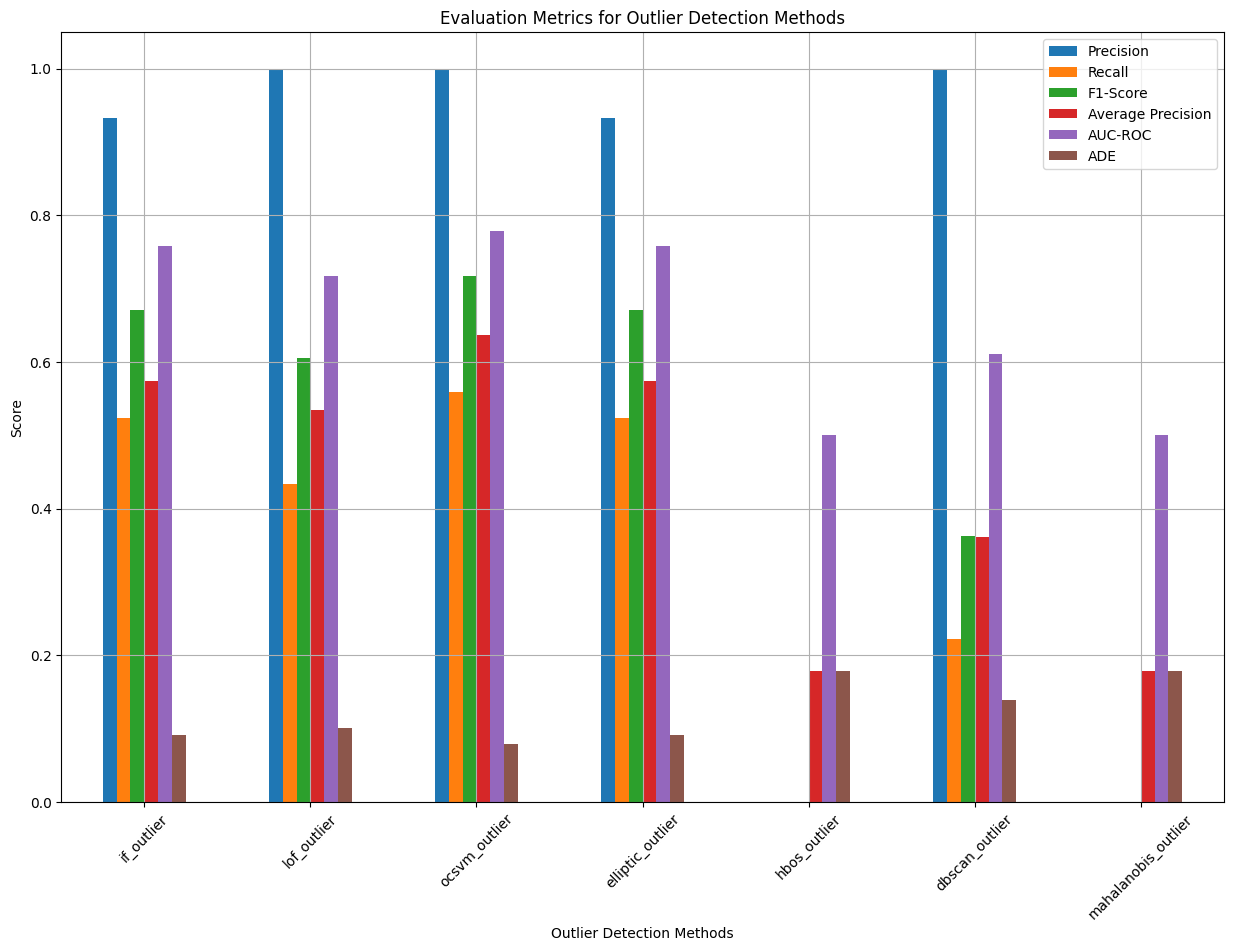

In [38]:
# Visualization
evaluation_df.plot(kind='bar', figsize=(15, 10))
plt.title('Evaluation Metrics for Outlier Detection Methods')
plt.ylabel('Score')
plt.xlabel('Outlier Detection Methods')
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

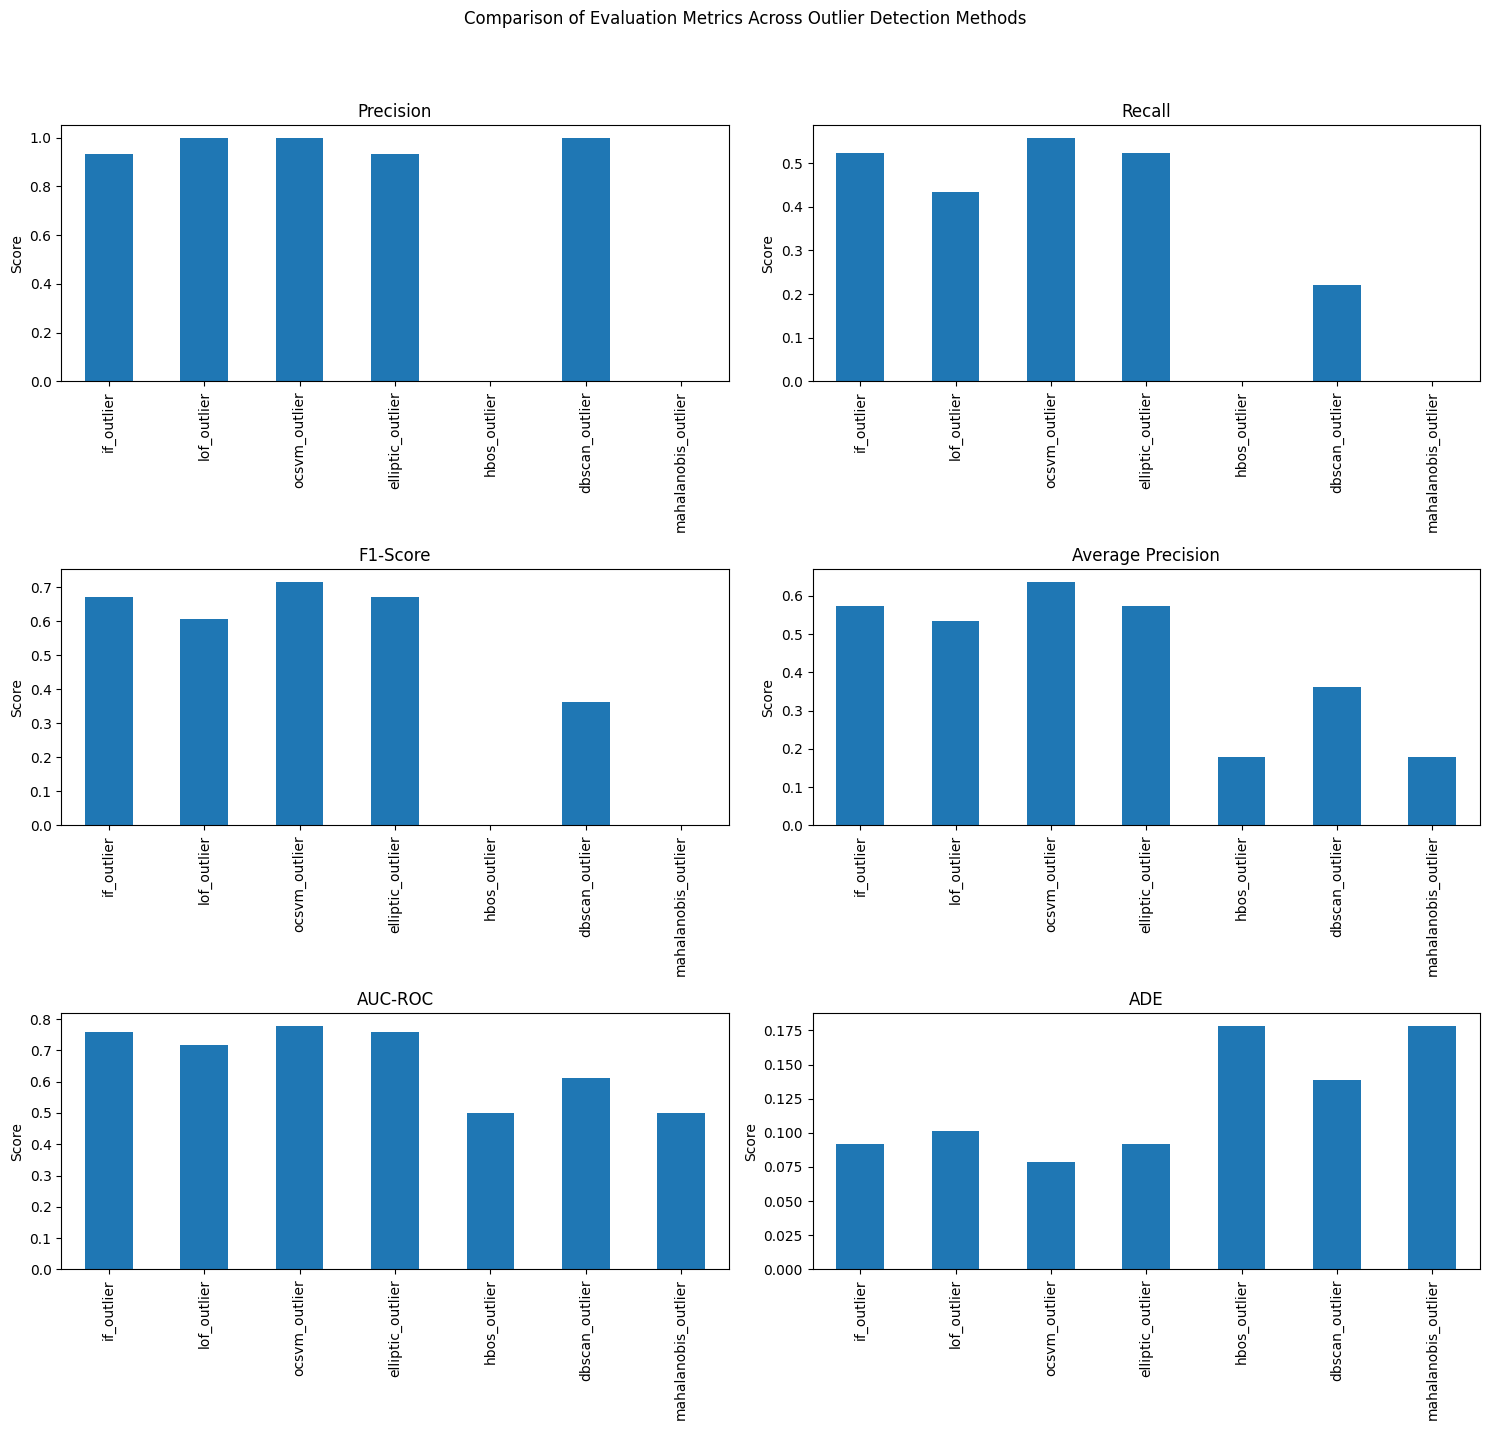

,Date,Year,Experiment,DataUse,Replication,Month,Vegetation,VegType,N2O,N_rate,...,SOM,if_outlier,lof_outlier,ocsvm_outlier,elliptic_outlier,hbos_outlier,dbscan_outlier,mahalanobis_distance,mahalanobis_outlier,majority_voting
0,2/9/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.896742,170,...,1.174072,1,1,1,1,0,0,0.125380,0,1
1,2/10/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,2.190218,170,...,1.174072,1,1,1,1,0,0,0.185283,0,1
2,2/18/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.542594,170,...,1.174072,1,1,1,1,0,0,0.137812,0,1
3,2/19/12,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.342870,170,...,1.174072,1,1,1,1,0,0,0.144823,0,1
4,3/16/12,2012,BCSE_KBS,Building,R1,March,Corn,Annual,2.947778,170,...,1.174072,1,1,1,1,0,0,0.158691,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,10/16/2013,2013,MCSE-T2,Testing,R4,October,TRIAE,Annual,1.640000,91,...,1.806000,1,1,1,1,0,0,0.204597,0,1
2242,11/15/2013,2013,MCSE-T2,Testing,R1,November,TRIAE,Annual,0.990000,91,...,1.496400,1,1,1,1,0,0,0.227413,0,1
2243,11/15/2013,2013,MCSE-T2,Testing,R2,November,TRIAE,Annual,-0.200000,91,...,1.186800,1,1,1,1,0,0,0.269185,0,1
2244,11/15/2013,2013,MCSE-T2,Testing,R3,November,TRIAE,Annual,0.300000,91,...,1.823200,1,1,1,1,0,0,0.251634,0,1


In [39]:
# Visualization of comparison of metrics across methods
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Comparison of Evaluation Metrics Across Outlier Detection Methods')

# Precision
evaluation_df[['Precision']].plot(kind='bar', ax=axes[0, 0], legend=False)
axes[0, 0].set_title('Precision')
axes[0, 0].set_ylabel('Score')

# Recall
evaluation_df[['Recall']].plot(kind='bar', ax=axes[0, 1], legend=False)
axes[0, 1].set_title('Recall')
axes[0, 1].set_ylabel('Score')

# F1-Score
evaluation_df[['F1-Score']].plot(kind='bar', ax=axes[1, 0], legend=False)
axes[1, 0].set_title('F1-Score')
axes[1, 0].set_ylabel('Score')

# Average Precision
evaluation_df[['Average Precision']].plot(kind='bar', ax=axes[1, 1], legend=False)
axes[1, 1].set_title('Average Precision')
axes[1, 1].set_ylabel('Score')

# AUC-ROC
evaluation_df[['AUC-ROC']].plot(kind='bar', ax=axes[2, 0], legend=False)
axes[2, 0].set_title('AUC-ROC')
axes[2, 0].set_ylabel('Score')

# ADE
evaluation_df[['ADE']].plot(kind='bar', ax=axes[2, 1], legend=False)
axes[2, 1].set_title('ADE')
axes[2, 1].set_ylabel('Score')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
data

In [ ]:
# Calculate evaluation metrics for each method and ROC curves
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, roc_curve, auc


evaluation_metrics = {}
roc_curves = {}
methods=['if_outlier', 'lof_outlier', 'ocsvm_outlier', 'elliptic_outlier', 'hbos_outlier', 'dbscan_outlier', 'mahalanobis_outlier']
# methods = ['IF_Outlier', 'LOF_Outlier', 'OCSVM_Outlier', 'Elliptic_Outlier', 'HBOS_Outlier', 'DBSCAN_Outlier', 'Mahalanobis_Outlier']

for method in methods:
    y_pred = (data[method] == -1).astype(int)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    ade = np.mean(np.abs(y_true - y_pred))

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_curves[method] = (fpr, tpr, roc_auc)

    evaluation_metrics[method] = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Average Precision': ap,
        'AUC-ROC': auc_roc,
        'ADE': ade
    }

# Convert the evaluation metrics to a DataFrame for better visualization
evaluation_df = pd.DataFrame(evaluation_metrics).T

# Save the evaluation results to a CSV file
evaluation_df.to_csv('dataset/09_03_04_AgricultureOutliersEvaluation.csv', index=True)

# Save the updated data with outlier detection results
data.to_csv('dataset/09_03_4_AgricultureOutliersResult.csv', index=False)

# Display the evaluation results
print(evaluation_df)

# Visualization of AUC-ROC curves
plt.figure(figsize=(10, 8))

for method, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, lw=2, label=f'{method} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()